In [139]:
import pandas as pd
import numpy as np
import joblib
import os

import plydata.cat_tools as cat
import plotnine as pn

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

pn.options.dpi = 300

In [140]:
my_file = "\data\CDNOW_master.txt"
data = pd.read_csv(str(os.getcwd())+ my_file, 
sep= "\s+",
names=["customer_id","date", "quantity", "price"])

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [142]:
data = data.assign(date = lambda x:x ["date"].astype(str))
data["date"] = pd.to_datetime(data["date"]).dropna()
data

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [143]:
data_first_purchase = data.sort_values(["customer_id", "date"]).groupby("customer_id").first()
data_first_purchase

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


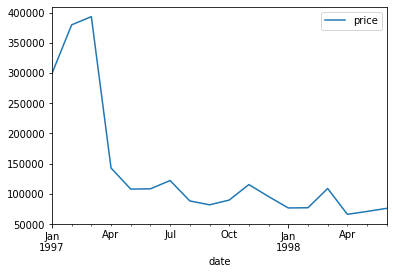

In [144]:
plot_customer = data.reset_index().set_index("date")[["price"]].resample(rule="MS").sum().plot()

In [145]:
ids = data["customer_id"].unique()
ids_selected = ids[0:10]

In [146]:
data_customer_id_subset_df = data[data["customer_id"].isin(ids_selected)].groupby(["customer_id", "date"]).sum().reset_index()
data_customer_id_subset_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,6,89.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54
5,3,1997-11-15,5,57.45
6,3,1997-11-25,4,20.96
7,3,1998-05-28,1,16.99
8,4,1997-01-01,2,29.33
9,4,1997-01-18,2,29.73


C:\Users\emire\AppData\Roaming\Python\Python39\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


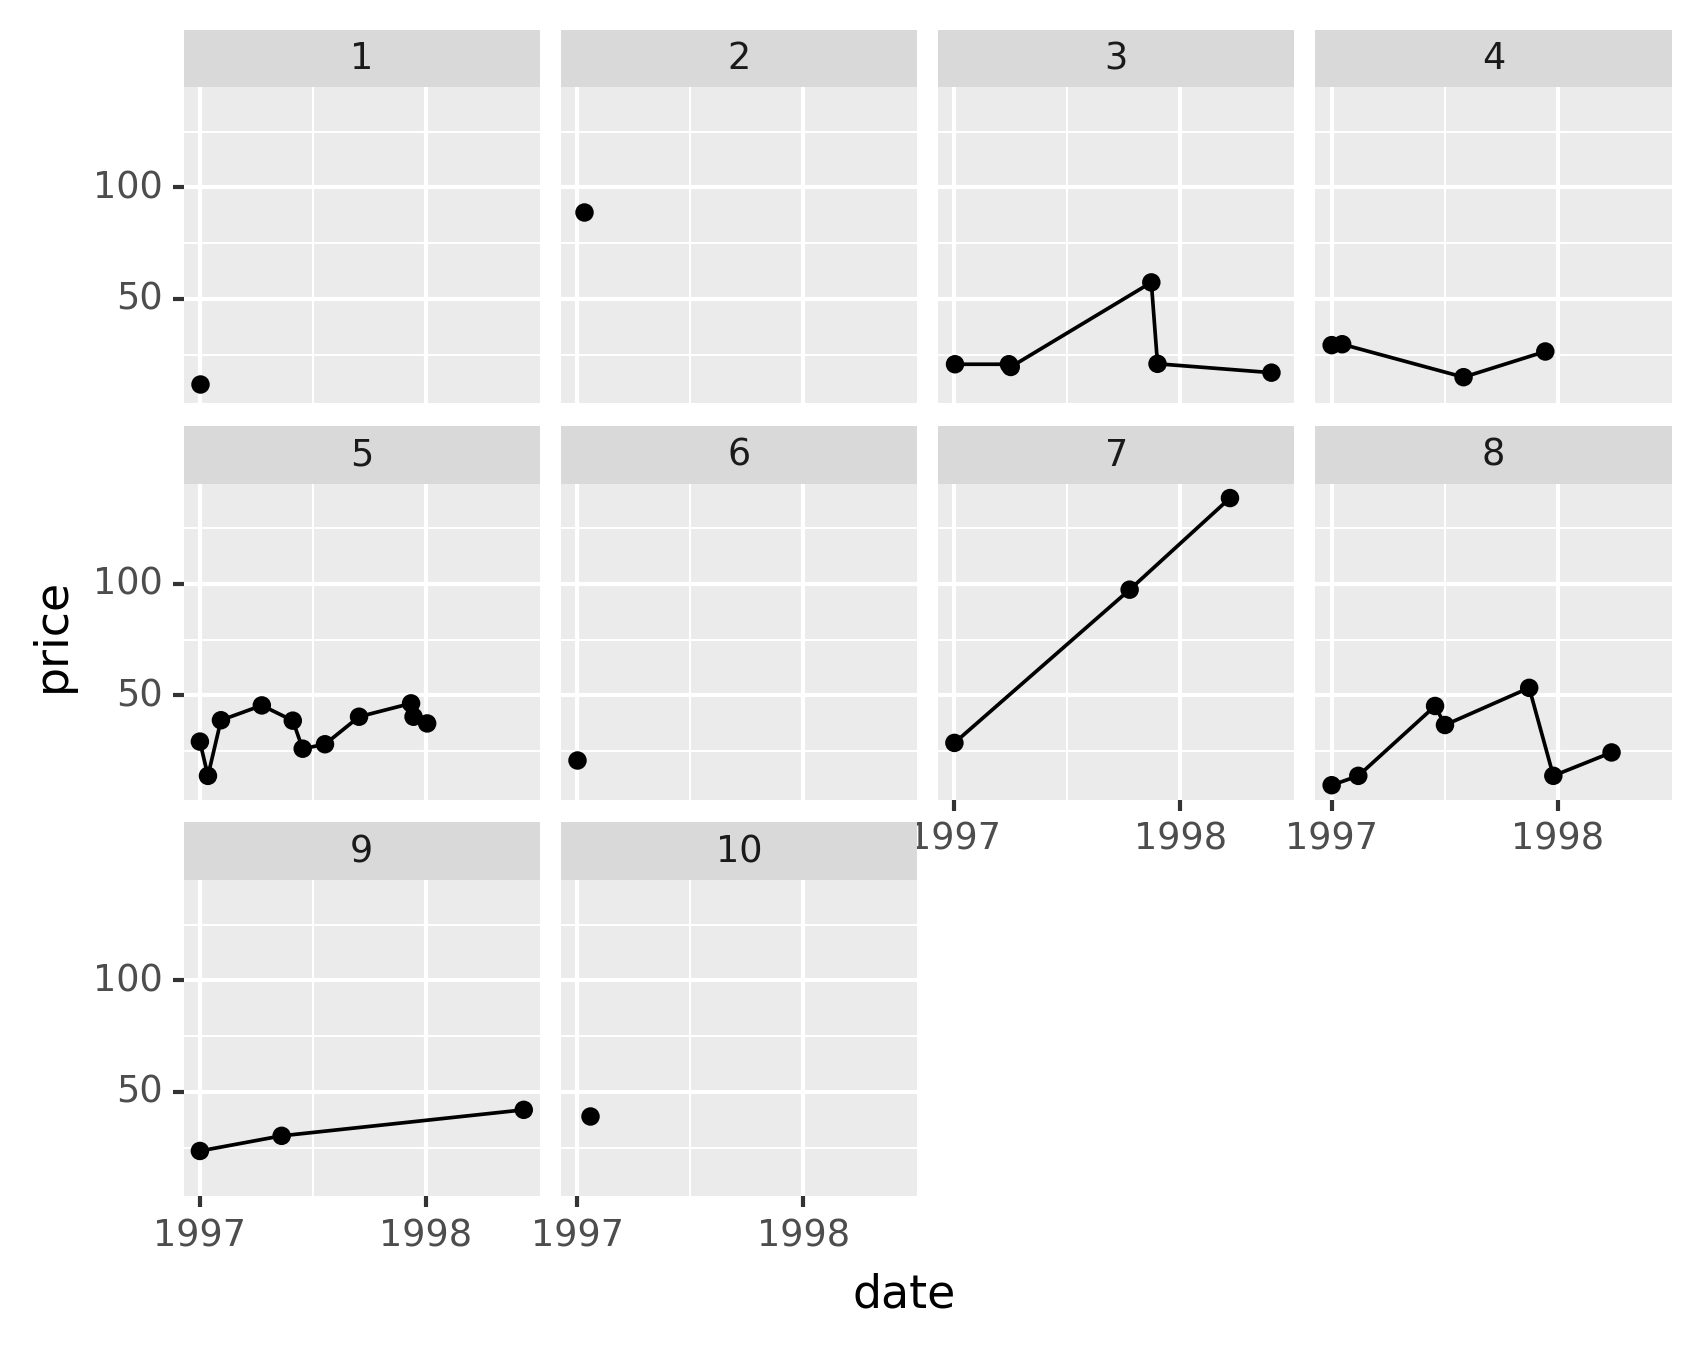

<ggplot: (160828285889)>

In [147]:
pn.ggplot(
    data=data_customer_id_subset_df
)+ pn.aes('date','price', group='customer_id')\
    +pn.geom_line()\
    +pn.geom_point()\
    +pn.facet_wrap('customer_id')\
    +pn.scale_x_date(
        date_breaks = "1 year",
        date_labels = "%Y"
    )

In [148]:
n_days = 90
max_date = data['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

In [149]:
temporal_in_df = data[data["date"] <= cutoff]
temporal_in_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [150]:
temporal_out_df = data[data["date"] > cutoff]
temporal_out_df

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99
69,25,1998-05-25,1,10.49
70,25,1998-06-03,3,24.97
...,...,...,...,...
69583,23534,1998-05-02,1,10.48
69623,23555,1998-05-01,4,49.96
69624,23555,1998-06-10,2,27.48
69631,23556,1998-06-07,2,28.98


In [151]:
targets_df = temporal_out_df.drop('quantity', axis=1).groupby('customer_id').sum().rename({"price":"spend_90_total"},axis=1).assign(spend_90_flag= 1)
targets_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [152]:
max_date = temporal_in_df["date"].max()

In [153]:
recency_features_df = temporal_in_df[["customer_id","date"]].groupby("customer_id").apply(lambda x : (x['date'].max()-max_date) / pd.to_timedelta(1, "day")).to_frame().set_axis(["recency"], axis=1)
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [154]:
frequency_features_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id').count().set_axis(['frequency'], axis=1)
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [155]:
price_features_df = temporal_in_df.groupby('customer_id').aggregate({'price':['sum', 'mean']}).set_axis(['price_sum', 'price_mean'], axis =1)
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [156]:
features_df = pd.concat(
    [recency_features_df, frequency_features_df, price_features_df], axis=1
).merge(
    targets_df,
    left_index= True,
    right_index= True,
    how = 'left'
).fillna(0)

features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


In [157]:
x = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
y_spend = features_df['spend_90_total']

In [158]:
xgb_reg_spec = XGBRegressor(
    objective = "reg:squarederror",
    random_state = 42
)

In [159]:
xgb_reg_model = GridSearchCV(
    estimator= xgb_reg_spec,
    param_grid=dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ),
    scoring='neg_mean_absolute_error',
    refit=True,
    cv = 5
)

In [160]:
xgb_reg_model.fit(x, y_spend)
xgb_reg_model.best_score_

-9.798940736745038

In [161]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [162]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [163]:
predictions_reg = xgb_reg_model.predict(x)
predictions_reg

array([0.76148176, 1.7241197 , 8.92676   , ..., 3.2925851 , 0.8648808 ,
       2.1359034 ], dtype=float32)

In [164]:
y_prob = features_df['spend_90_flag']

In [165]:
features_df['spend_90_flag']

customer_id
1        0.0
2        0.0
3        1.0
4        0.0
5        0.0
        ... 
23566    0.0
23567    0.0
23568    0.0
23569    0.0
23570    0.0
Name: spend_90_flag, Length: 23570, dtype: float64

In [166]:
xgb_clf_spec = XGBClassifier(
    objective = "binary:logistic",
    random_state = 42
 )

In [167]:
xgb_clf_model  = GridSearchCV(
    estimator= xgb_clf_spec,
    param_grid=dict(
        learning_rate = [ 0.1, 0.3, 0.5]
    ),
    scoring='roc_auc',
    refit=True,
    cv = 5
)

In [168]:
xgb_clf_model.fit(x, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [169]:
xgb_clf_model.best_score_

0.8322431280502023

In [170]:
xgb_clf_model.best_params_

{'learning_rate': 0.1}

In [171]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [179]:
predictiosn_clf = xgb_clf_model.predict_proba(x)
predictiosn_clf

array([[0.9863565 , 0.01364353],
       [0.97774523, 0.02225477],
       [0.73073196, 0.26926804],
       ...,
       [0.91439575, 0.08560423],
       [0.94483334, 0.05516665],
       [0.92201537, 0.07798463]], dtype=float32)

In [173]:
imp_spend_amount_dict = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type= 'gain')

In [174]:
imp_spend_amount_df =  pd.DataFrame(
    data= {
        'feature':list(imp_spend_amount_dict.keys()),
        'value': list(imp_spend_amount_dict.values())
    }
).assign(
    feature = lambda x: cat.cat_reorder(x['feature'], x['value'])
)

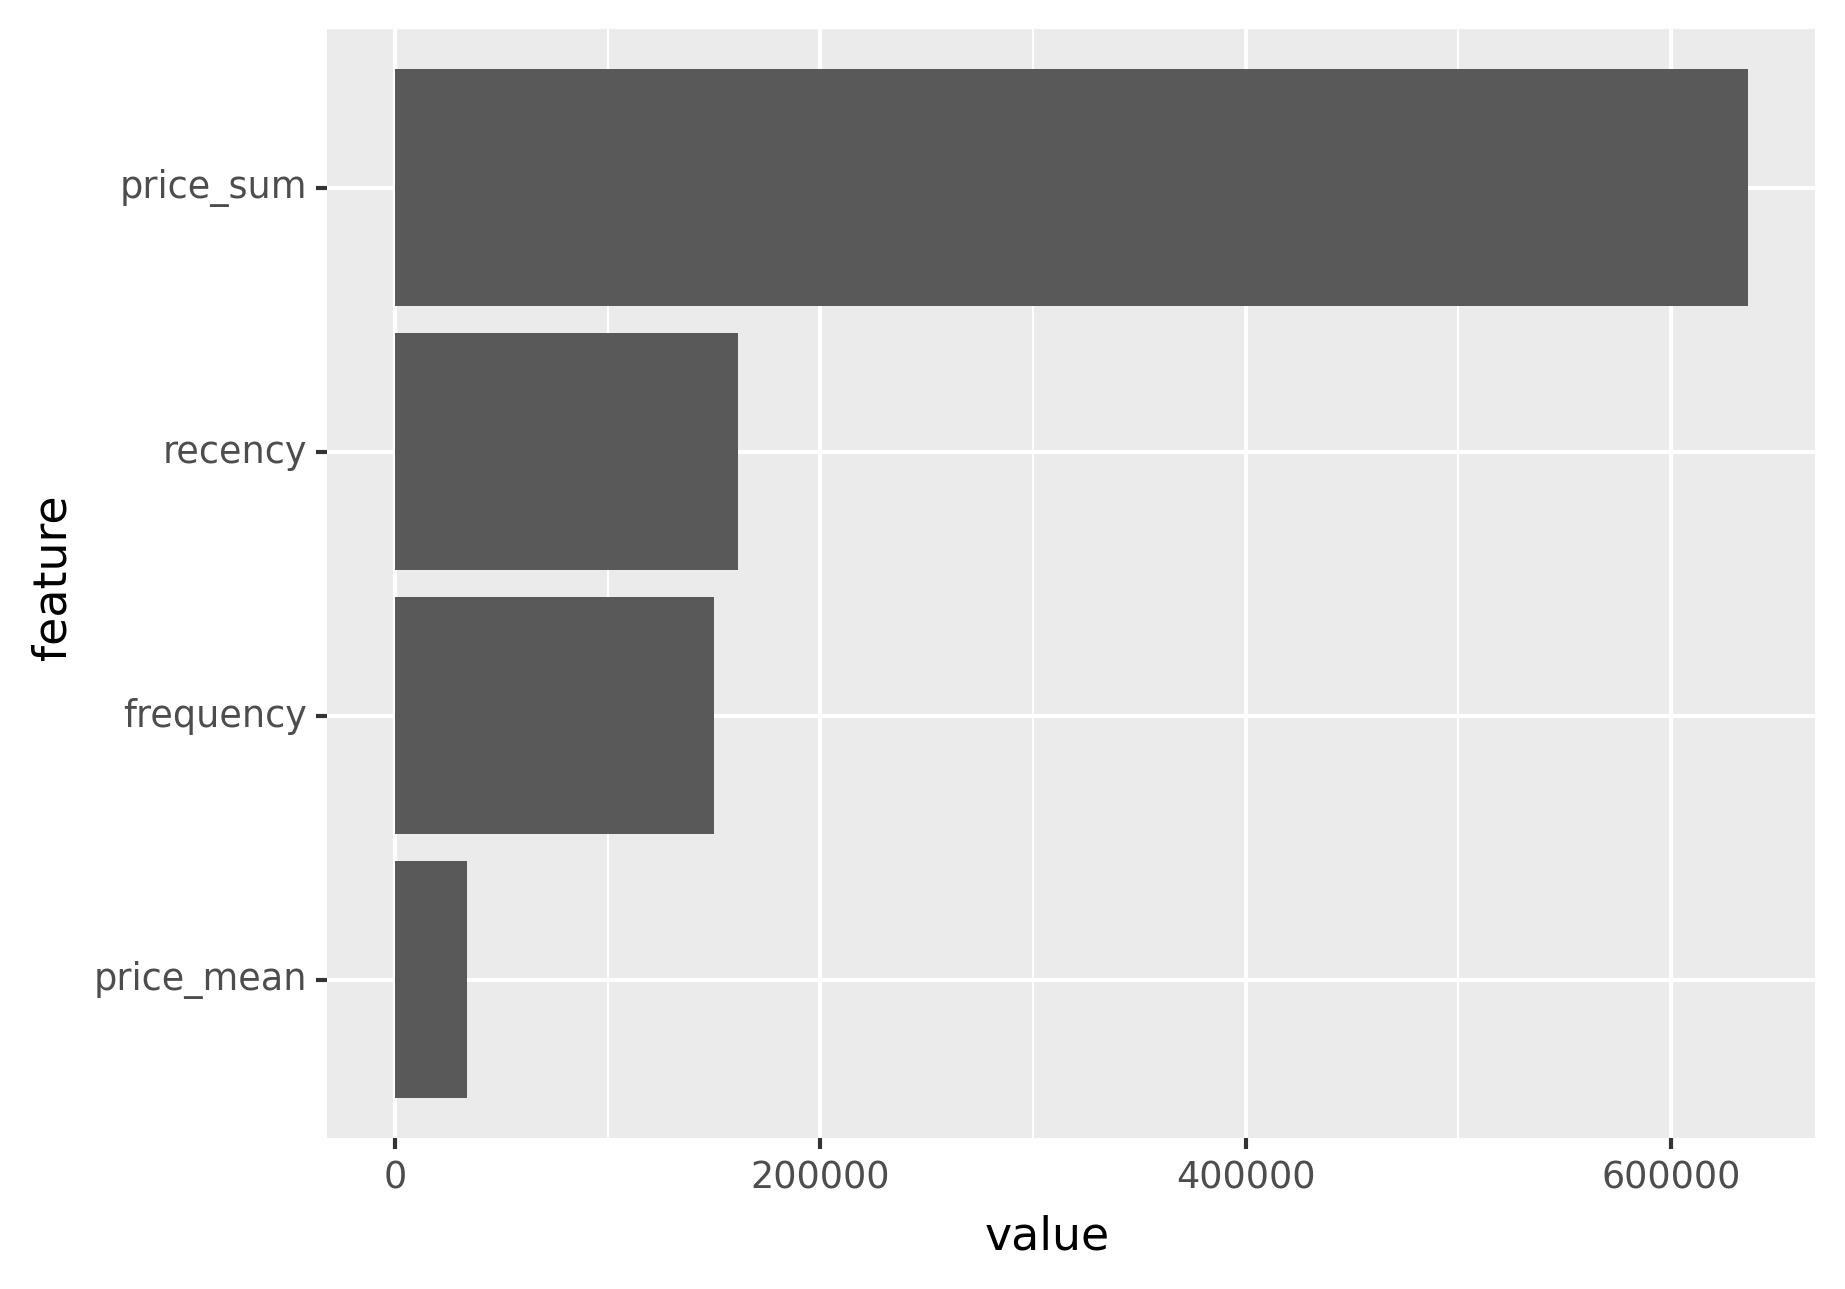

<ggplot: (160826746986)>

In [175]:
pn.ggplot(
    data = imp_spend_amount_df
)+pn.aes('feature', 'value')\
+pn.geom_col()\
+pn.coord_flip()

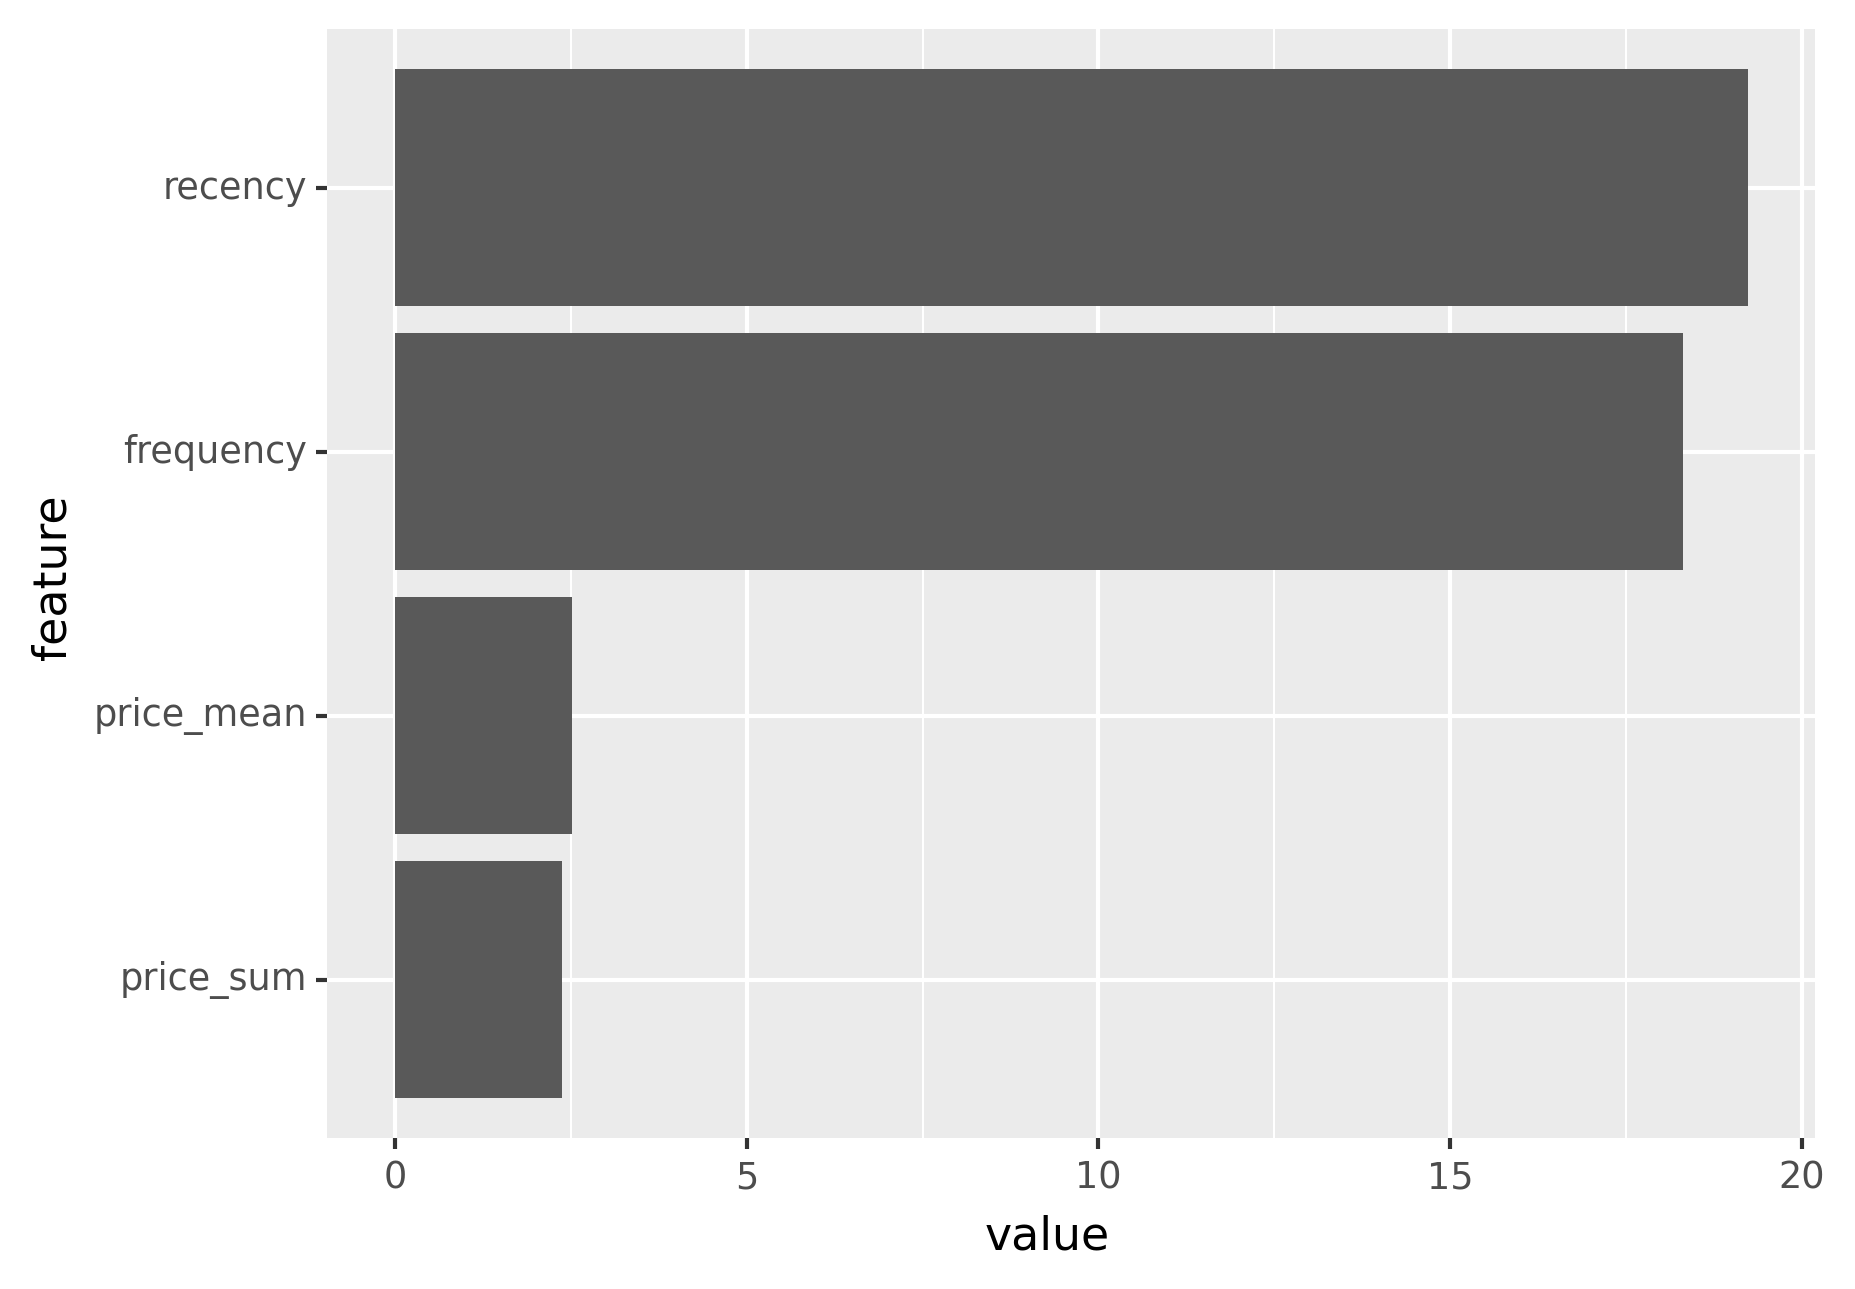

<ggplot: (160826343933)>

In [176]:
imp_spend_prob_dict = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type= 'gain')
imp_spend_prob_df =  pd.DataFrame(
    data= {
        'feature':list(imp_spend_prob_dict.keys()),
        'value': list(imp_spend_prob_dict.values())
    }
).assign(
    feature = lambda x: cat.cat_reorder(x['feature'], x['value'])
)
pn.ggplot(
    data = imp_spend_prob_df
)+pn.aes('feature', 'value')\
+pn.geom_col()\
+pn.coord_flip()



In [177]:
predictions_df = pd.concat(
    [pd.DataFrame(predictions_reg).set_axis(
        ['pred_spend'], axis=1),
    pd.DataFrame(predictiosn_clf)[[1]].set_axis(
        ['pred_prob'], axis=1),
        features_df.reset_index()], 
        axis=1
)
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.761482,0.013644,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.724120,0.022255,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.926760,0.269268,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.594741,0.271697,4,-110.0,4,100.50,25.125000,0.00,0.0
4,16.058043,0.458857,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.864881,0.031896,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.864881,0.036808,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.292585,0.085604,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.864881,0.055167,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [178]:
predictions_df.sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
709,141.295868,0.994131,710,-2.0,51,2216.45,43.459804,285.85,1.0
10078,121.122620,0.993090,10079,0.0,62,2100.38,33.877097,100.43,1.0
3048,493.399597,0.991593,3049,-1.0,97,3484.03,35.917835,778.82,1.0
2483,112.719429,0.991409,2484,0.0,59,1438.93,24.388644,345.43,1.0
14047,1009.602539,0.991252,14048,0.0,180,7267.15,40.373056,1709.18,1.0
...,...,...,...,...,...,...,...,...,...
1281,1.432225,0.003567,1282,-450.0,1,283.97,283.970000,0.00,0.0
774,1.432225,0.003314,775,-452.0,1,186.67,186.670000,0.00,0.0
1482,1.432225,0.003147,1483,-450.0,1,163.52,163.520000,0.00,0.0
290,1.432225,0.003084,291,-454.0,1,199.15,199.150000,0.00,0.0
